In [ ]:
import requests
import collections
import math
import re

## Part 1: Text attribution

In [ ]:
# Computes the global vocabulary.
urls = [
    "https://storage.googleapis.com/research-share/texts/t1.txt",
    "https://storage.googleapis.com/research-share/texts/t2.txt",
    "https://storage.googleapis.com/research-share/texts/t3.txt",
    "https://storage.googleapis.com/research-share/texts/t4.txt",
    "https://storage.googleapis.com/research-share/texts/t5.txt",
    # "https://storage.googleapis.com/research-share/texts/t6.txt",
    # "https://storage.googleapis.com/research-share/texts/t7.txt",
    "https://storage.googleapis.com/research-share/texts/t8.txt",
    "https://storage.googleapis.com/research-share/texts/t9.txt",
    "https://storage.googleapis.com/research-share/texts/t10.txt",
]

# We compute the book tokens once and forall, as this is an expensive operation.
book_tokens = []
all_tokens = []
for u in urls:
    text = requests.get(u).text
    author_tokens = re.findall(r'[a-zA-Z]+', text)
    book_tokens.append(author_tokens)
    all_tokens.extend(author_tokens)

Now we filter all the tokens, dropping both those that are very common, and fairly rare.

In [ ]:
LOW_THRESHOLD =25
HIGH_THRESHOLD = 1000

c = collections.Counter(all_tokens)
most_common = [t for t, _ in c.most_common(HIGH_THRESHOLD)[LOW_THRESHOLD:]]

def filter_tokens(tokens):
    return [t for t in tokens if t in most_common]

book_tokens = [filter_tokens(tokens) for tokens in book_tokens]

Computes the probability of tokens in the union of the books.

In [ ]:
c = collections.Counter(all_tokens)
num_tokens = len(all_tokens)
vocabulary_probs = {word: count / num_tokens for word, count in c.items()}

Let's now build our `Author` class, this time with methods to compute the distribution distance between two authors, using KL-divergence and Earth Mover's Distance (EMD).

Complete the class below, inserting code where `### YOUR SOLUTION HERE` appears.

We remind you of the main formulas.

For a word $w$, let:
* $P(w)$ be the probability of word $w$ in the general vocabulary.
* $K_w$ be the number of times the author uses $w$ in the author's text.
* $K$ be the number of words in the author's text.
* $\alpha$ be the Laplace smooting coefficient.

Then, the probability that the author generates word $w$ is given by:

$$\theta_w = \frac{K_w + \alpha P(w)}{K + \alpha}$$

Given this word probability, you have to compute the distance between the author's vocabulary, and the vocabulary of another author.  You should do so using two versions of distance:

* KL-Divergence
* Earth Mover's Distance
* Jensen-Shannon Divergence

The Jenssen-Shannon Divergence is a symmetrized and smoothed version of KL-Divergence.  It is defined as follows:

$$JSD(P || Q) = \frac{1}{2} KL(P || M) + \frac{1}{2} KL(Q || M)$$

where $M = \frac{1}{2}(P + Q)$.

In [ ]:
# You can use this code cell to define any code that is useful to you
# (e.g., define a function that you use later in the class).
# Just write it here.  Or, you can also leave this cell blank if you don't need
# any definition.

### YOUR SOLUTION HERE

In [ ]:
class Author(object):

    def __init__(self, name, author_tokens, vocabulary_probabilities, alpha=100):
        """Initializes the author with the given name and text.
        Also tokenizes the text with spaCy, and stores the list of tokens.
        @param name: name of the author.
        @param text: tokenized text constituting writing sample for the author.
        @param vocabulary_probabilities: dictionary mapping each word to its probability
            in the vocabulary (general vocabulary, not by the author).
        @param alpha: value to be used in the Laplace smoothing function.
        """
        self.name = name
        self.text = text
        self.alpha = alpha
        self.author_tokens = author_tokens
        self.num_tokens = len(self.author_tokens)
        self.vocabulary = vocabulary_probabilities
        # We also build for you a dictionary mapping each word to its number of occurrences in the
        self.word_frequencies = {w: c for w, c in collections.Counter(self.author_tokens).items()}
        # Here you can add any other initialization code you want.
        ### YOUR SOLUTION HERE

    def theta(self, word):
        """Returns the probability that an author generates a given word.
        This is the theta in the above mathematical formula.
        You use this to compute the probability distribution of author words.
        The domain of this distribution is the vocabulary.
        """
        ### YOUR SOLUTION HERE
        kw = self.word_frequencies.get(word, 0)
        pw = self.vocabulary.get(word, 0)
        return (kw + (self.alpha * pw)) / (self.num_tokens + self.alpha)

    def kl_divergence(self, other):
        """Computes KL(other || self). This is the KL divergence."""
        ### YOUR SOLUTION HERE
        total = 0
        for word in other.word_frequencies.keys():
          px = other.theta(word)
          qx = self.theta(word)
          if qx == 0:
            continue
          total += (px * math.log(px / qx))
        return total

    def js_divergence(self, other):
        """Computes the Jensen-Shannon divergence between self and other."""
        # pass
        ### YOUR SOLUTION HERE
        words = set(self.word_frequencies.keys()).union(set(other.word_frequencies.keys()))

        m = {}
        for word in words:
          p = self.theta(word)
          q = other.theta(word)
          m[word] = (p + q) / 2

        kl_self_m = 0
        kl_other_m = 0

        for word in words:
          p = self.theta(word)
          q = other.theta(word)
          m_prob = m[word]

          if p > 0 and q > 0:
            kl_self_m += p * math.log(p / m_prob)
          if q > 0 and m_prob > 0:
            kl_other_m += q * math.log(q / m_prob)
        jsd = (0.5 * kl_self_m) + (0.5 * kl_other_m)
        return jsd


    def em_distance(self, other):
        """Computes the earth mover's distance between self and other."""
        ### YOUR SOLUTION HERE
        words = set(self.word_frequencies.keys()).union(set(other.word_frequencies.keys()))

        total = 0
        for word in words:
          p = self.theta(word)
          q = other.theta(word)
          total += abs(p - q)
        emd = 0.5 * total
        return emd


Ok.  Now, we can create our three authors.

In [ ]:
true_books = {
    'doyle': book_tokens[0],
    'austin': book_tokens[1],
    'christie': book_tokens[2],
}

# We can build authors from these writing samples.
authors = {
    name: Author(name, tokens, vocabulary_probs) for name, tokens in true_books.items()
}


Let's create our 8 unknown authors for the 8 pieces of text.
Of course, you do know the authors of 0, 1, 2, as they have been chosen as
Doyle, Austin, Christie.

In [ ]:
unknown_authors = [Author(f"unknown_{i}",t, vocabulary_probs) for i, t in enumerate(book_tokens[0:])]

We can then print the JS-distance between each unknown author and Doyle, just as a test.
I print it in both directions, so you can check it's symmetric.
I will also include a test to help you debug your code.

In [ ]:
for u in unknown_authors:
    print(authors['doyle'].js_divergence(u), u.js_divergence(authors['doyle']))

0.0 0.0
0.18859853719894465 0.18859853719894465
0.16622858885787872 0.16622858885787872
0.10739191699610635 0.10739191699610635
0.16507635547606891 0.1650763554760689
0.1794005828499619 0.1794005828499619
0.15850572859540715 0.15850572859540718
0.18414293798998269 0.18414293798998269


First, the test.

In [ ]:
# Tests 10 points: JS divergence.

assert authors['doyle'].js_divergence(authors['doyle']) == 0
assert 0.175 <= authors['doyle'].js_divergence(unknown_authors[5]) <= 0.185



Now let's look at the Earth-Mover's distance.  Again let's print it in both directions.

In [ ]:
for u in unknown_authors:
    print(authors['doyle'].em_distance(u), u.em_distance(authors['doyle']))

0.0 0.0
0.44618954454960985 0.44618954454960985
0.4084918731044849 0.4084918731044849
0.30848535413164 0.30848535413164
0.40879577593571553 0.40879577593571553
0.43056901511518286 0.43056901511518286
0.38508390817162214 0.38508390817162214
0.4289887148145943 0.4289887148145942


Again, here is a test to help you debug your code.

In [ ]:
# Tests 10 points: JS divergence between known authors.

assert authors['doyle'].em_distance(authors['doyle']) == 0
assert 0.43 <= authors['doyle'].em_distance(unknown_authors[5]) <= 0.44



Now we would like to combine JS and EMD into a single distance.  
We cannot do so by simply adding them, as they are expressed in different units.
One way would be to somehow normalize them and then add them, but that's not very satisfactory.
Instead, one thing you can always do with quantities expressed in different units is to multiply them.
This suggests using the _geometric mean_ $g(d_1, d_2)$ of the two distances $d_1$ and $d_2$, defined as:

$$g(d_1, d_2) = \sqrt{d_1 \cdot d_2}$$

We leave it to you to implement.

Note that using the geometric mean implies that if one distance is zero, so will be the combined distance.
If this is not what is intended, one can compute the geometric mean of the inverses of the distances, and then invert the result (careful about division by zero).  We are not going to follow this approach, because in our case, if one distance is zero, they all are.

In [ ]:
def geometric_mean(d1, d2):
    """Computes the geometric mean of two distances."""
    ### YOUR SOLUTION HERE
    return math.sqrt(d1 * d2)

Now let's compute the combined distance between the three known authors and each unknown author.

In [ ]:
real_authors = ['doyle', 'austin', 'christie']
for a in real_authors:
    print(f"Distances to {a}:")
    for i, u in enumerate(unknown_authors):
        em = authors[a].em_distance(u)
        js = authors[a].js_divergence(u)
        print(geometric_mean(em, js), u.name if i > 2 else real_authors[i])
    print()

Distances to doyle:
0.0 doyle
0.2900873927207451 austin
0.26058209383238556 christie
0.1820132784865422 unknown_3
0.25977397257130974 unknown_4
0.2779286460025268 unknown_5
0.24705870847859185 unknown_6
0.2810609227738822 unknown_7

Distances to austin:
0.2900873927207451 doyle
0.0 austin
0.3316369213546566 christie
0.2793740592983807 unknown_3
0.3058089474134614 unknown_4
0.3076363344405622 unknown_5
0.3159298400647696 unknown_6
0.11203694637580915 unknown_7

Distances to christie:
0.26058209383238556 doyle
0.33163692135465656 austin
0.0 christie
0.22661455273138312 unknown_3
0.27063545470799977 unknown_4
0.3054650165769652 unknown_5
0.14694113973744824 unknown_6
0.3162758081772721 unknown_7



In the above, every known author has authored exactly one of the unknown texts
(there are some unknown texts by other authors in the mix).
Can you propose a threshold `t` on the combined distance, so that if the combined distance between a known author and an unknown text is less than `t`, we can attribute the unknown text to the known author?

In [ ]:
t = 0.0 # This does not work; please assign the proper value to t below the `YOUR SOLUTION HERE` comment.
### YOUR SOLUTION HERE
t = 0.2

A proper threshold should lead to exactly one unknown text being attributed to each known author.

In [ ]:
# Tests 10 points: identifying unknown authors using a threshold.

real_authors = ['doyle', 'austin', 'christie']
for a in real_authors:
    candidates = set()
    for u in unknown_authors[3:]:
        em = authors[a].em_distance(u)
        js = authors[a].js_divergence(u)
        if geometric_mean(em, js) < t:
            candidates.add(u.name)
    assert len(candidates) == 1, f"Too few or many candidates for {a}: {len(candidates)}"

## Part 2: Experimenting with algorithm running times

In [ ]:
import numpy as np
import pandas as pd

This is a Pandas dataframe that contains the running time of two algorithms, a baseline algorithm, and a proposed one.

In [ ]:
df = pd.read_csv("https://storage.googleapis.com/research-share/class_data/experiment_data.csv")
# df = pd.read_csv("experiment_data.csv")
df

,baseline,proposed
0,10.468354,10.260609
1,10.773350,8.710510
2,6.559294,12.279273
3,8.642563,8.655421
4,6.857395,11.083264
...,...,...
995,10.591735,10.798005
996,10.304661,8.316180
997,10.400740,9.385383
998,13.058192,13.881584


As you can see, the times are variable.  If you are unfamiliar with Pandas, you can ignore the details of dataframes, and you can
get the list of times for each algorithm by using `df['baseline']` and `df['proposed']`.

Your task is to propose a value of `N` (the input size) beyond which the proposed algorithm is faster than the baseline algorithm, with a significance value $t=3$ according to Welch's t-test.

We do this in two steps.  The first step is to compute the mean, and sample variance, of each of the two series.
For a series $x_1, x_2, \ldots, x_n$, the mean is given by:

$$\mu = \frac{1}{n} \sum_{i=1}^n x_i$$

and the sample variance $s^2$ is given by:

$$s^2 = \frac{1}{n-1} \sum_{i=1}^n (x_i - \mu)^2$$

We have you implement these.

In [ ]:
def mean(data):
    """Computes the mean of a list of numbers."""
    ### YOUR SOLUTION HERE
    return sum(data) / len(data)

def sample_stdev(data):
    """Computes the sample standard deviation of a list of numbers."""
    ### YOUR SOLUTION HERE
    variance = 0
    total = 0
    u = mean(data)

    if len(data) == 1:
      return 0

    for x in data:
      total += (x - u) ** 2

    variance = (1 / (len(data) - 1)) * total
    stdev = math.sqrt(variance)
    return stdev


Let's test these functions before we go any further.

In [ ]:
# Tests 10 points: mean and sample standard deviation.

data = [1, 2, 3, 4, 5, 6, 7]
assert mean(data) == 4
assert round(sample_stdev(data), 2) == 2.16, round(sample_stdev(data), 2)
assert round(mean(df['baseline'][:10]), 2) == 9.78, round(mean(df['baseline'][:10]), 2)
assert round(sample_stdev(df['baseline'][:10]), 2) == 2.56, round(sample_stdev(df['baseline'][:10]), 2)



Good.  Now, if I give you a value of n, we can compute the value of Welch's t-test statistic.
You proceed as follows.  

First, you compute $\mu_1, \mu_2$, and $s_1^2, s_2^2$, looking at the first
$n$ values of each of the `baseline`, `proposed` data series (1=`\baseline`, 2=`proposed`, in the subscripts).

Then, you compute the t-statistic as follows:

$$t = \frac{|\mu_1 - \mu_2|}{\sqrt{\frac{s_1^2}{n} + \frac{s_2^2}{n}}}$$

We let you do it.

In [ ]:
def welch_t_value(n):
    """Computes the Welch t-value for the experiment, if we stop after n
    data points."""
    ### YOUR SOLUTION HERE
    baseline = df["baseline"].head(n)
    proposed = df["proposed"].head(n)

    u1 = mean(baseline)
    u2 = mean(proposed)
    s1 = sample_stdev(baseline)
    s2 = sample_stdev(proposed)

    if n == 0:
      return 0
    if math.sqrt(((s1 ** 2) / n) + ((s2 ** 2) / n)) == 0:
      return 0

    t_top = abs(u1 - u2)
    t_bottom = math.sqrt(((s1 ** 2) / n) + ((s2 ** 2) / n))
    return t_top / t_bottom


Let's test your solution, to help you debug.

In [ ]:
# Tests 10 points: Welch t-value.

assert round(welch_t_value(10), 2) == 0.14, round(welch_t_value(10), 2)
assert round(welch_t_value(20), 2) == 1.21, round(welch_t_value(20), 2)



Ok. Now, suppose you want to find the smallest value of `N` such that the proposed algorithm is significantly faster than the baseline algorithm, with significance value $t=2$.  You can do so by trying all possible values of `N`, and stopping when you find the first one that works.  What is the value of N?

We let you implement in the following cell; at the end of it, you have to report the value of `N` you found.

In [ ]:
N = 1 # This is just a placeholder. Please assign the proper value to N below the `YOUR SOLUTION HERE` comment.

### YOUR SOLUTION HERE
while N <= len(df):
  if welch_t_value(N) >= 2:
    break
  else:
    N += 1
print(N)

42


In [ ]:
# Tests 10 points: determining N.

# This is just an easy test.  When grading, we will test for the minimum value of N
# that yields t > 2.0.

assert 2 <= N <= 1000 # Just to make sure you assigned something reasonable to N.


Hmmm.  Who knows.  Is this really enough? Suppose you decide to run the experiment more times.
What is the minimum value of the Welch t-statistic you can get, for any value of `N` greater than
the threshold you found?  Assign this value to the variable `min_t_stat_after_stopping`.

In [ ]:
# This is just a placeholder. Please assign the proper value to min_t_stat_after_stopping
# below the `YOUR SOLUTION HERE` comment.
min_t_stat_after_stopping = 1000

# Note: min_t_stat_after_stopping can be computed in one line of code.
# You can use a longer solution, of course.

### YOUR SOLUTION HERE
for n in range(N, len(df) + 1):
  if welch_t_value(n) < min_t_stat_after_stopping:
    min_t_stat_after_stopping = welch_t_value(n)

In [ ]:
# Tests 10 points: minimum t-statistic after stopping.

# This is just a very wide test.  The real test is hidden.
assert 0.1 <= min_t_stat_after_stopping <= 2.1


Hmmm. Ok, what can you conclude from this?  Was it really a good idea to stop so early?
Did this teach you something about being careful with experiments?

Purely for the sake of curiosity / education, let's plot how the t-statistic varies with `N`.

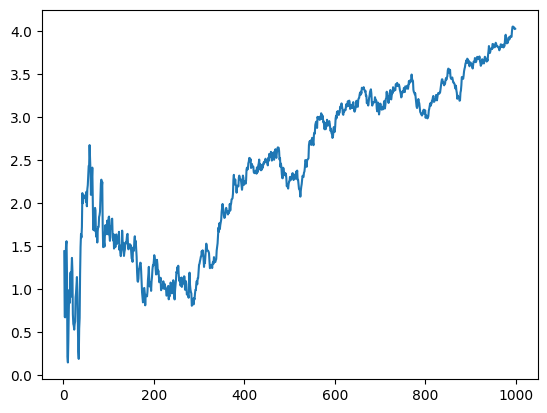

In [ ]:
import matplotlib.pyplot as plt

ns = range(2, 1000)
ts = [welch_t_value(nn) for nn in ns]
plt.plot(ns, ts)

Isn't this somewhat scary?  Does this teach you about the value of being curious about data, and gathering more evidence than you think you need?

Ignore the cells below.  They were used to generate the data.

In [ ]:
# # Define parameters
# k = 10        # Shape parameter
# theta1 = 1    # Scale parameter (must be chosen)
# theta2 = 1.05
# n_samples = 1000

# # Generate random numbers
# random_samples1 = np.random.gamma(shape=k, scale=theta1, size=n_samples)
# random_samples2 = np.random.gamma(shape=k, scale=theta2, size=n_samples)

# df = pd.DataFrame({'baseline': random_samples1, 'proposed': random_samples2})


In [ ]:
# df.to_csv("experiment_data.csv", index=False)